# Transient Flamelet Example: Ignition and Advanced Time Integration

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_
- Computing a transient ignition trajectory
- Advanced time integration parameters

## Introduction 

In this demonstration we repeatedly compute the ignition trajectory of a hydrogen flamelet, using different time steppers, target errors for adaptive time step selection, and more.

In [1]:
from spitfire import ChemicalMechanismSpec, FlameletSpec, Flamelet
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter

Just as a reminder, here we build the chemical mechanism instace from a Cantera solution instead of simply providing the XML file and group name directly. Either works, but sometimes you might already have a Cantera solution available. 

Following that, we build a preheated air stream and a fuel mixture of Nitrogen and Hydrogen that gives a chosen stoichiometric mixture fraction. These are sent to a `FlameletSpec` object for later.

In [2]:
sol = ct.Solution('h2-burke.xml', 'h2-burke')
mech = ChemicalMechanismSpec.from_solution(sol)

Tair = 1200.
pressure = 101325.
zstoich = 0.1

air = mech.stream(stp_air=True)
air.TP = Tair, pressure
fuel = mech.mix_fuels_for_stoich_mixture_fraction(mech.stream('X', 'H2:1'), mech.stream('X', 'N2:1'), zstoich, air)
fuel.TP = 300., pressure

flamelet_specs = FlameletSpec(mech_spec=mech, 
                              initial_condition='unreacted',
                              oxy_stream=air,
                              fuel_stream=fuel,
                              grid_points=34,
                              max_dissipation_rate=1.e3)

## Baseline Ignition Trajectory

First, we'll simply call `integrate_to_steady` without any parameters to compute a flamelet ignition trajectory with the default time integration settings.

In [3]:
ft = Flamelet(flamelet_specs)
output = ft.integrate_to_steady()

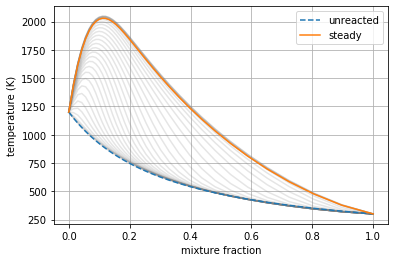

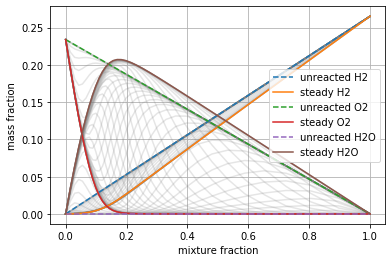

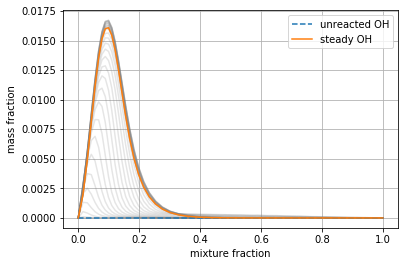

In [4]:
for i in range(0, output.time_values.size, 20):
    plt.plot(output.mixture_fraction_values, output['temperature'][i, :], color='gray', alpha=0.2)
plt.plot(output.mixture_fraction_values, output['temperature'][0, :], '--', label='unreacted')
plt.plot(output.mixture_fraction_values, output['temperature'][-1, :], label='steady')
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('temperature (K)')
plt.legend()
plt.show()

for i in range(0, output.time_values.size, 20):
    plt.plot(output.mixture_fraction_values, output['mass fraction H2'][i, :], color='gray', alpha=0.2)
    plt.plot(output.mixture_fraction_values, output['mass fraction O2'][i, :], color='gray', alpha=0.2)
    plt.plot(output.mixture_fraction_values, output['mass fraction H2O'][i, :], color='gray', alpha=0.2)
plt.plot(output.mixture_fraction_values, output['mass fraction H2'][0, :], '--', label='unreacted H2')
plt.plot(output.mixture_fraction_values, output['mass fraction H2'][-1, :], label='steady H2')
plt.plot(output.mixture_fraction_values, output['mass fraction O2'][0, :], '--',label='unreacted O2')
plt.plot(output.mixture_fraction_values, output['mass fraction O2'][-1, :], label='steady O2')
plt.plot(output.mixture_fraction_values, output['mass fraction H2O'][0, :],'--', label='unreacted H2O')
plt.plot(output.mixture_fraction_values, output['mass fraction H2O'][-1, :], label='steady H2O')
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('mass fraction')
plt.legend()
plt.show()

for i in range(0, output.time_values.size, 20):
    plt.plot(output.mixture_fraction_values, output['mass fraction OH'][i, :], color='gray', alpha=0.2)
plt.plot(output.mixture_fraction_values, output['mass fraction OH'][0, :], '--', label='unreacted OH')
plt.plot(output.mixture_fraction_values, output['mass fraction OH'][-1, :], label='steady OH')
plt.grid()
plt.xlabel('mixture fraction')
plt.ylabel('mass fraction')
plt.legend()
plt.show()

## Time Steppers and Target Error

Now we import some of Spitfire's built-in time stepping methods. These include BDF-1 (Backward Euler) and some implicit Runge-Kutta methods of orders 3-5. The `SimpleNewtonSolver` is needed as the nonlinear solver for the implicit time methods.

In [5]:
from spitfire import (SimpleNewtonSolver,
                      BackwardEulerS1P1Q1,
                      KennedyCarpenterS6P4Q3,
                      KvaernoS4P3Q2,
                      KennedyCarpenterS4P3Q2,
                      KennedyCarpenterS8P5Q4)

To run with a custom stepper, provide the `stepper_type` argument. A related parameter in these adaptive steppers is the `transient_tolerance`, which should be decreased to improve accuracy through smaller time steps. This parameter relates to efficiency through the order of the integration technique - for first-order (P1) Backward Euler the relationship is linear and a ten times reduction in the tolerance should roughly correspond to a ten times increase in run time. For the P3, P4, and P5 methods, however, a factor of ten increase in run time can enable a tolerance 1000, 10000, and 100000 times smaller, respectively. This gives high-order methods a dramatic advantage in solving to extreme accuracy, and in practice their better stability also makes them faster at computing flamelet solutions without concern of error.

Below we iterate over some combinations of methods and tolerances, followed by some results and discussion.

In [6]:
output_dict = dict()

for name, method, tol in [('BDF1', BackwardEulerS1P1Q1, 1e-7),
                          ('Kv-P3', KvaernoS4P3Q2, 1e-7),
                          ('KC-P3', KennedyCarpenterS4P3Q2, 1e-7),
                          ('KC-P4', KennedyCarpenterS6P4Q3, 1e-7),
                          ('KC-P5', KennedyCarpenterS8P5Q4, 1e-7),
                          ('BDF1', BackwardEulerS1P1Q1, 1e-8),
                          ('Kv-P3', KvaernoS4P3Q2, 1e-10),
                          ('KC-P3', KennedyCarpenterS4P3Q2, 1e-10),
                          ('KC-P4', KennedyCarpenterS6P4Q3, 1e-11),
                          ('KC-P5', KennedyCarpenterS8P5Q4, 1e-12)]:
    print(f'Running w/{name:5}, tolerance {tol:5.1e} ... ', end='')
    
    tic = perf_counter()
    ft = Flamelet(flamelet_specs)
    the_output = ft.integrate_to_steady(stepper_type=method, transient_tolerance=tol)
    dcput = perf_counter() - tic
    nsteps = the_output.time_values.size
    output_dict[(name, tol)] = (the_output, nsteps, dcput)
    
    print(f'done in {nsteps:5} time steps in {dcput:4.1f} s, mean cput/step of {dcput*1e3/nsteps:3.1f} ms')

Running w/BDF1 , tolerance 1.0e-07 ... done in  5199 time steps in  5.8 s, mean cput/step of 1.1 ms
Running w/Kv-P3, tolerance 1.0e-07 ... done in   872 time steps in  2.3 s, mean cput/step of 2.7 ms
Running w/KC-P3, tolerance 1.0e-07 ... done in   396 time steps in  2.0 s, mean cput/step of 5.0 ms
Running w/KC-P4, tolerance 1.0e-07 ... done in   153 time steps in  1.1 s, mean cput/step of 7.2 ms
Running w/KC-P5, tolerance 1.0e-07 ... done in   112 time steps in  1.1 s, mean cput/step of 9.5 ms
Running w/BDF1 , tolerance 1.0e-08 ... done in 16227 time steps in 20.4 s, mean cput/step of 1.3 ms
Running w/Kv-P3, tolerance 1.0e-10 ... done in  8580 time steps in 12.9 s, mean cput/step of 1.5 ms
Running w/KC-P3, tolerance 1.0e-10 ... done in  3677 time steps in  7.3 s, mean cput/step of 2.0 ms
Running w/KC-P4, tolerance 1.0e-11 ... done in  1169 time steps in  4.4 s, mean cput/step of 3.7 ms
Running w/KC-P5, tolerance 1.0e-12 ... done in   774 time steps in  4.2 s, mean cput/step of 5.5 ms


From the plot of maximum flamelet temperature, we can see that the ignition delay time seems similar across all of the methods and target errors. This is a typical observation in transient flamelet models - a solution that stays stable will usually be sufficiently accurate (in terms of time integration error - other errors are still relevant).

Some interesting observations can be made from the efficiency numbers.

1. Higher-order methods are the fastest for a given tolerance, both for high, stability-limited values and lower values meant for accurate simulations.
2. Higher-order methods require more CPU time per step but take fewer steps.
3. Higher-order methods are significantly faster at computing solutions with lower tolerances
4. Decreasing the tolerance decreases the CPU time per step

The first three conclusions are not surprising, but the fourth one is confusing at first. The reason the CPU time per step decreases with tolerance is that Spitfire, similarly to other advanced ODE solvers, not only adaptively changes the time step size but also adaptively evaluates/factorizes the Jacobian matrix. Expensive calculations with the Jacobian are kept to a minimum, and can be minimized further when the error tolerance is lower. This is because smaller time steps fail less frequently and give smoother behavior when nonlinear transients appear suddenly. Jacobian reuse is why KC-P4 (Spitfire's default stepper) is nearly twice as fast per time step at the lower tolerance ($10^{-11}$) than the higher one - however, the increase in time step count does still increase the runtime.

The second plot below shows the time step size history for each solver. Observe especially how BDF-1 with tolerance of $10^{-8}$ requires the smallest step size, compared to the higher-order methods with much lower tolerances. The fifth-order method (KC-P5) is always taking a time step at least an order of magnitude larger, even at a tolerance of $10^{-12}$.

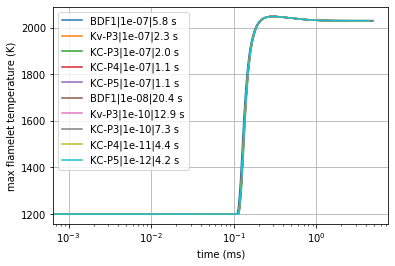

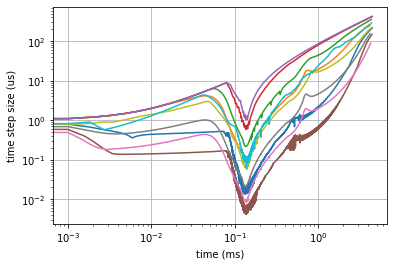

In [7]:
for name, transient_tol in output_dict:
    output, nsteps, dcput = output_dict[(name, transient_tol)]
    plt.semilogx(output.time_values * 1.e3, np.max(output['temperature'], axis=1), label=f'{name}|{transient_tol}|{dcput:.1f} s')
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('max flamelet temperature (K)')
plt.legend()
plt.show()

for name, transient_tol in output_dict:
    output, nsteps, dcput = output_dict[(name, transient_tol)]
    t = output.time_values
    dt = t[1:] - t[:-1]
    plt.loglog(t[:-1] * 1.e3, dt * 1.e6, label=f'{name}/{transient_tol:.1e} | {dcput:.1f} s')
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('time step size (us)')
plt.show()

## Jacobian/Preconditioner Reuse

We can roughly control the degree of Jacobian/preconditioner reuse with the `maximum_steps_per_jacobian` argument to `integrate_to_steady`, which maps to the `linear_setup_rate` argument in Spitfire's `odesolve` method. Setting this argument to 1 means we always re-evaluate the Jacobian on every time step. Setting it to 20, for instance, simply means that a maximum of 20 steps can occur between re-evaluation/factorization. The default setting in `integrate_to_steady` is 10, and while it is tempting to increase it further, this can negatively impact stability and force smaller time steps during nonlinear transients.

Other parameters such as `time_step_increase_factor_to_force_jacobian` and `time_step_decrease_factor_to_force_jacobian` to `odesolve` can be used to control Jacobian/preconditioner reuse.

Also we can build the nonlinear solver differently. The `SimpleNewtonSolver` class can be built with the `evaluate_jacobian_every_iter` argument set to True. This can be provided through `integrate_to_steady` with the `extra_nlsolver_args` argument (takes a dictionary of keyword arguments to be passed to the nonlinear solver construction). This goes a step further than `maximum_steps_per_jacobian=1`, never reusing the Jacobian matrix even between nonlinear solver iterations. This improves stability quite a bit, and reduces nonlinear iteration count, but for larger mechanisms (more species) this is extremely costly. For hydrogen, however, it's still pretty cheap and works out well in the end.

Below we run the fifth-order method with different values of `maximum_steps_per_jacobian` and then with the Jacobian re-evaluated at every Newton iteration. This enables us to get past the $10^{-7}$ tolerance limit imposed by stability on the lagged Jacobian runs, leading to very fast solutions. I'll repeat it though - this option is much slower (take a look at the CPU time per step) and is impractical for larger mechanisms where the Jacobian evaluation/factorization is the dominant cost.

In [8]:
for name, method, tol, mspj, nlsa in [('KC-P5-1Jac', KennedyCarpenterS8P5Q4, 1e-12, 1, dict()),
                                      ('KC-P5-2Jac', KennedyCarpenterS8P5Q4, 1e-12, 2, dict()),
                                      ('KC-P5-5Jac', KennedyCarpenterS8P5Q4, 1e-12, 5, dict()),
                                      ('KC-P5-20Jac', KennedyCarpenterS8P5Q4, 1e-12, 20, dict()),
                                      ('KC-P5-100Jac', KennedyCarpenterS8P5Q4, 1e-12, 100, dict()),
                                      ('KC-P5-fullJac', KennedyCarpenterS8P5Q4, 1e-12, 1, {'evaluate_jacobian_every_iter': True}),]:
    print(f'Running w/{name:15}, tolerance {tol:5.1e} ... ', end='')
    tic = perf_counter()
    ft = Flamelet(flamelet_specs)
    the_output = ft.integrate_to_steady(stepper_type=method, 
                                        transient_tolerance=tol, 
                                        maximum_steps_per_jacobian=mspj,
                                        extra_nlsolver_args=nlsa)
    dcput = perf_counter() - tic
    nsteps = the_output.time_values.size
    output_dict[(name, tol)] = (the_output, nsteps, dcput)
    print(f'done in {nsteps:5} time steps in {dcput:4.1f} s, mean cput/step of {dcput*1e3/nsteps:3.1f} ms')

Running w/KC-P5-1Jac     , tolerance 1.0e-12 ... done in   776 time steps in  3.5 s, mean cput/step of 4.5 ms
Running w/KC-P5-2Jac     , tolerance 1.0e-12 ... done in   774 time steps in  3.5 s, mean cput/step of 4.6 ms
Running w/KC-P5-5Jac     , tolerance 1.0e-12 ... done in   769 time steps in  3.8 s, mean cput/step of 5.0 ms
Running w/KC-P5-20Jac    , tolerance 1.0e-12 ... done in   778 time steps in  4.7 s, mean cput/step of 6.1 ms
Running w/KC-P5-100Jac   , tolerance 1.0e-12 ... done in   780 time steps in  5.6 s, mean cput/step of 7.2 ms
Running w/KC-P5-fullJac  , tolerance 1.0e-12 ... done in   773 time steps in  8.5 s, mean cput/step of 11.0 ms


In [9]:
for name, method, tol, mspj, nlsa in [('KC-P5-fullJac', KennedyCarpenterS8P5Q4, 1e-4, 1, {'evaluate_jacobian_every_iter': True}),
                                      ('KC-P5-fullJac', KennedyCarpenterS8P5Q4, 1e-7, 1, {'evaluate_jacobian_every_iter': True})]:
    print(f'Running w/{name:15}, tolerance {tol:5.1e} ... ', end='')
    tic = perf_counter()
    ft = Flamelet(flamelet_specs)
    the_output = ft.integrate_to_steady(stepper_type=method, 
                                        transient_tolerance=tol, 
                                        maximum_steps_per_jacobian=mspj,
                                        extra_nlsolver_args=nlsa)
    dcput = perf_counter() - tic
    nsteps = the_output.time_values.size
    output_dict[(name, tol)] = (the_output, nsteps, dcput)
    print(f'done in {nsteps:5} time steps in {dcput:4.1f} s, mean cput/step of {dcput*1e3/nsteps:3.1f} ms')

Running w/KC-P5-fullJac  , tolerance 1.0e-04 ... done in    72 time steps in  1.4 s, mean cput/step of 19.2 ms
Running w/KC-P5-fullJac  , tolerance 1.0e-07 ... done in   106 time steps in  1.8 s, mean cput/step of 17.4 ms


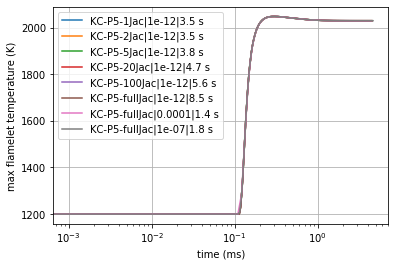

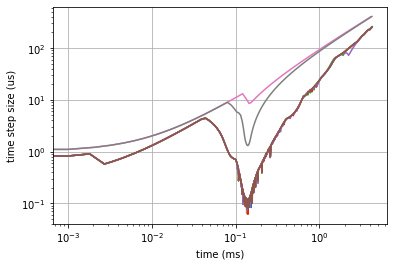

In [10]:
for name, transient_tol in output_dict:
    if 'KC-P5' in name and 'Jac' in name:
        output, nsteps, dcput = output_dict[(name, transient_tol)]
        plt.semilogx(output.time_values * 1.e3, np.max(output['temperature'], axis=1), label=f'{name}|{transient_tol}|{dcput:.1f} s')
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('max flamelet temperature (K)')
plt.legend()
plt.show()

for name, transient_tol in output_dict:
    if 'KC-P5' in name and 'Jac' in name:
        output, nsteps, dcput = output_dict[(name, transient_tol)]
        t = output.time_values
        dt = t[1:] - t[:-1]
        plt.loglog(t[:-1] * 1.e3, dt * 1.e6, label=f'{name}/{transient_tol:.1e} | {dcput:.1f} s')
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('time step size (us)')
plt.show()

## Conclusions

In this notebook we've solved a transient flamelet ignition problem with a number of different time integration settings. There's more that can be modified but these are the major options. We've shown the merit of high-order methods provided by Spitfire and shown some results regarding Jacobian/preconditioner reuse.